# NIMBY Rails Network Analysis

Visual exploration of a NIMBY Rails transit network built from a database created by [nimby2sql](https://github.com/rlvelte/nimby2sql).

**Usage:** Set `DB_PATH` below to your `.db` file.

In [1]:
import sqlite3

import folium
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from folium.plugins import HeatMap

sns.set_theme(style="darkgrid", palette="viridis")
plt.rcParams["figure.dpi"] = 120

# ---------- CONFIGURATION ----------
DB_PATH = "../nimby_rails.db"

# ---------- LOAD DATABASE CONTENT ----------
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query("SELECT * FROM line_stops_enriched", conn)
df_stations = pd.read_sql_query("SELECT * FROM stations", conn)
df_lines = pd.read_sql_query("SELECT * FROM lines", conn)

print(f"Loaded {len(df)} stop records, {len(df_stations)} stations, {len(df_lines)} lines")

Loaded 2947 stop records, 1374 stations, 140 lines


## 1. Station Density Heatmap (Interactive Map)
An interactive Folium map showing station density as a heatmap. Busier areas (more stations & lines) glow hotter.

In [2]:
# Weight by number of lines serving each station
station_weight = (
    df.groupby(["station_id", "station_name", "lat", "lon"])["line_id"]
    .nunique()
    .reset_index(name="lines_serving")
)

# Auto-fit map to data bounds
sw = [station_weight["lat"].min(), station_weight["lon"].min()]
ne = [station_weight["lat"].max(), station_weight["lon"].max()]
center_lat = (sw[0] + ne[0]) / 2
center_lon = (sw[1] + ne[1]) / 2

m = folium.Map(location=[center_lat, center_lon],
               tiles="CartoDB dark_matter")
m.fit_bounds([sw, ne], padding=[20, 20])

heat_data = station_weight[["lat", "lon", "lines_serving"]].values.tolist()
HeatMap(heat_data, radius=20, blur=15, max_zoom=13,
        gradient={0.2: "blue", 0.4: "lime", 0.6: "yellow", 1: "red"}).add_to(m)

# Add station markers
for _, row in station_weight.iterrows():
    folium.CircleMarker(
        [row["lat"], row["lon"]],
        radius=2 + row["lines_serving"] * 1.5,
        color="white", fill=True, fill_opacity=0.7,
        tooltip=f"{row['station_name']} ({int(row['lines_serving'])} lines)"
    ).add_to(m)

m

## 2. Top Hub Stations
Stations served by the most distinct lines - the major interchange hubs of the network.

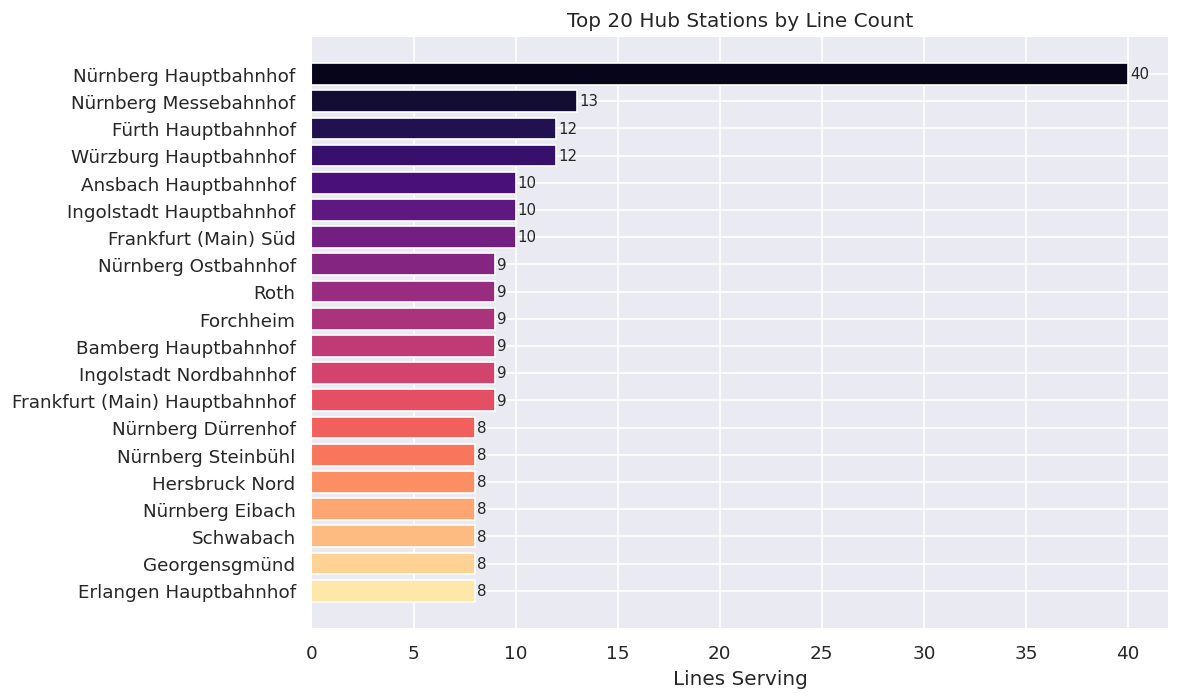

In [3]:
top_hubs = station_weight.nlargest(20, "lines_serving")

fig, ax = plt.subplots(figsize=(10, 6))
palette = sns.color_palette("magma", len(top_hubs))
bars = ax.barh(top_hubs["station_name"], top_hubs["lines_serving"],
               color=palette)
ax.set_xlabel("Lines Serving")
ax.set_title("Top 20 Hub Stations by Line Count")
ax.invert_yaxis()
for bar, val in zip(bars, top_hubs["lines_serving"]):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            str(int(val)), va="center", fontsize=9)
plt.tight_layout()
plt.show()

## 3. Station-Line Connectivity Heatmap
Which stations are served by which lines? A heatmap showing the connectivity matrix.

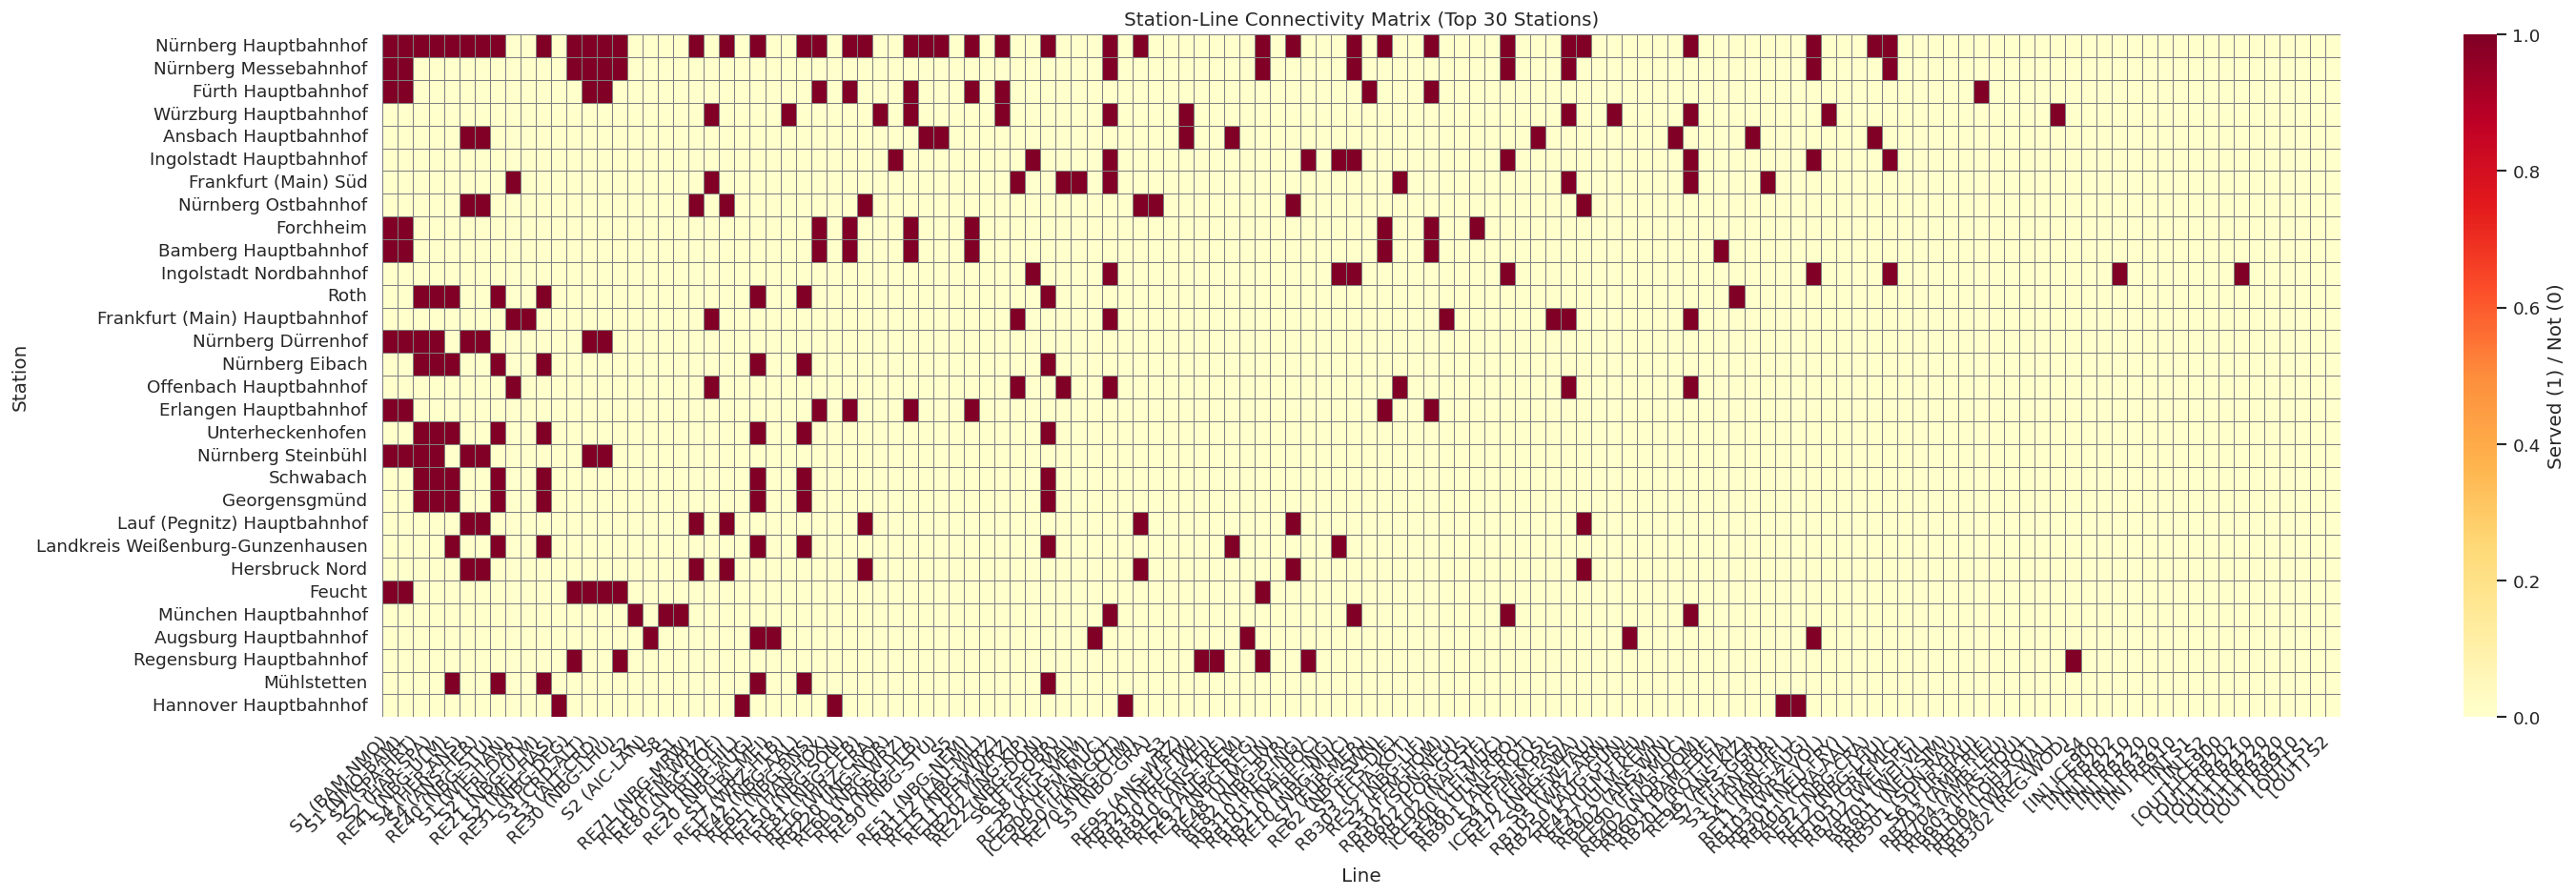

In [4]:
# Pivot: station vs line presence
pivot = df.pivot_table(index="station_name", columns="line_name",
                       values="stop_index", aggfunc="count", fill_value=0)
# Convert to binary (served / not served)
pivot_binary = (pivot > 0).astype(int)

# Sort stations by total connectivity, lines by number of stations
pivot_binary = pivot_binary.loc[
    pivot_binary.sum(axis=1).sort_values(ascending=False).index
]
pivot_binary = pivot_binary[
    pivot_binary.sum(axis=0).sort_values(ascending=False).index
]

# Show top 30 most connected stations
display_pivot = pivot_binary.head(30)

fig, ax = plt.subplots(figsize=(25, 8))
sns.heatmap(display_pivot, cmap="YlOrRd", linewidths=0.3, linecolor="gray",
            cbar_kws={"label": "Served (1) / Not (0)"},
            xticklabels=True, yticklabels=True, ax=ax)
ax.set_title("Station-Line Connectivity Matrix (Top 30 Stations)")
ax.set_xlabel("Line")
ax.set_ylabel("Station")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 4. Leg Distance Distribution
How far apart are consecutive stops on each line?

/tmp/ipykernel_17360/3606023681.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="leg_km", y="line_name", order=order,


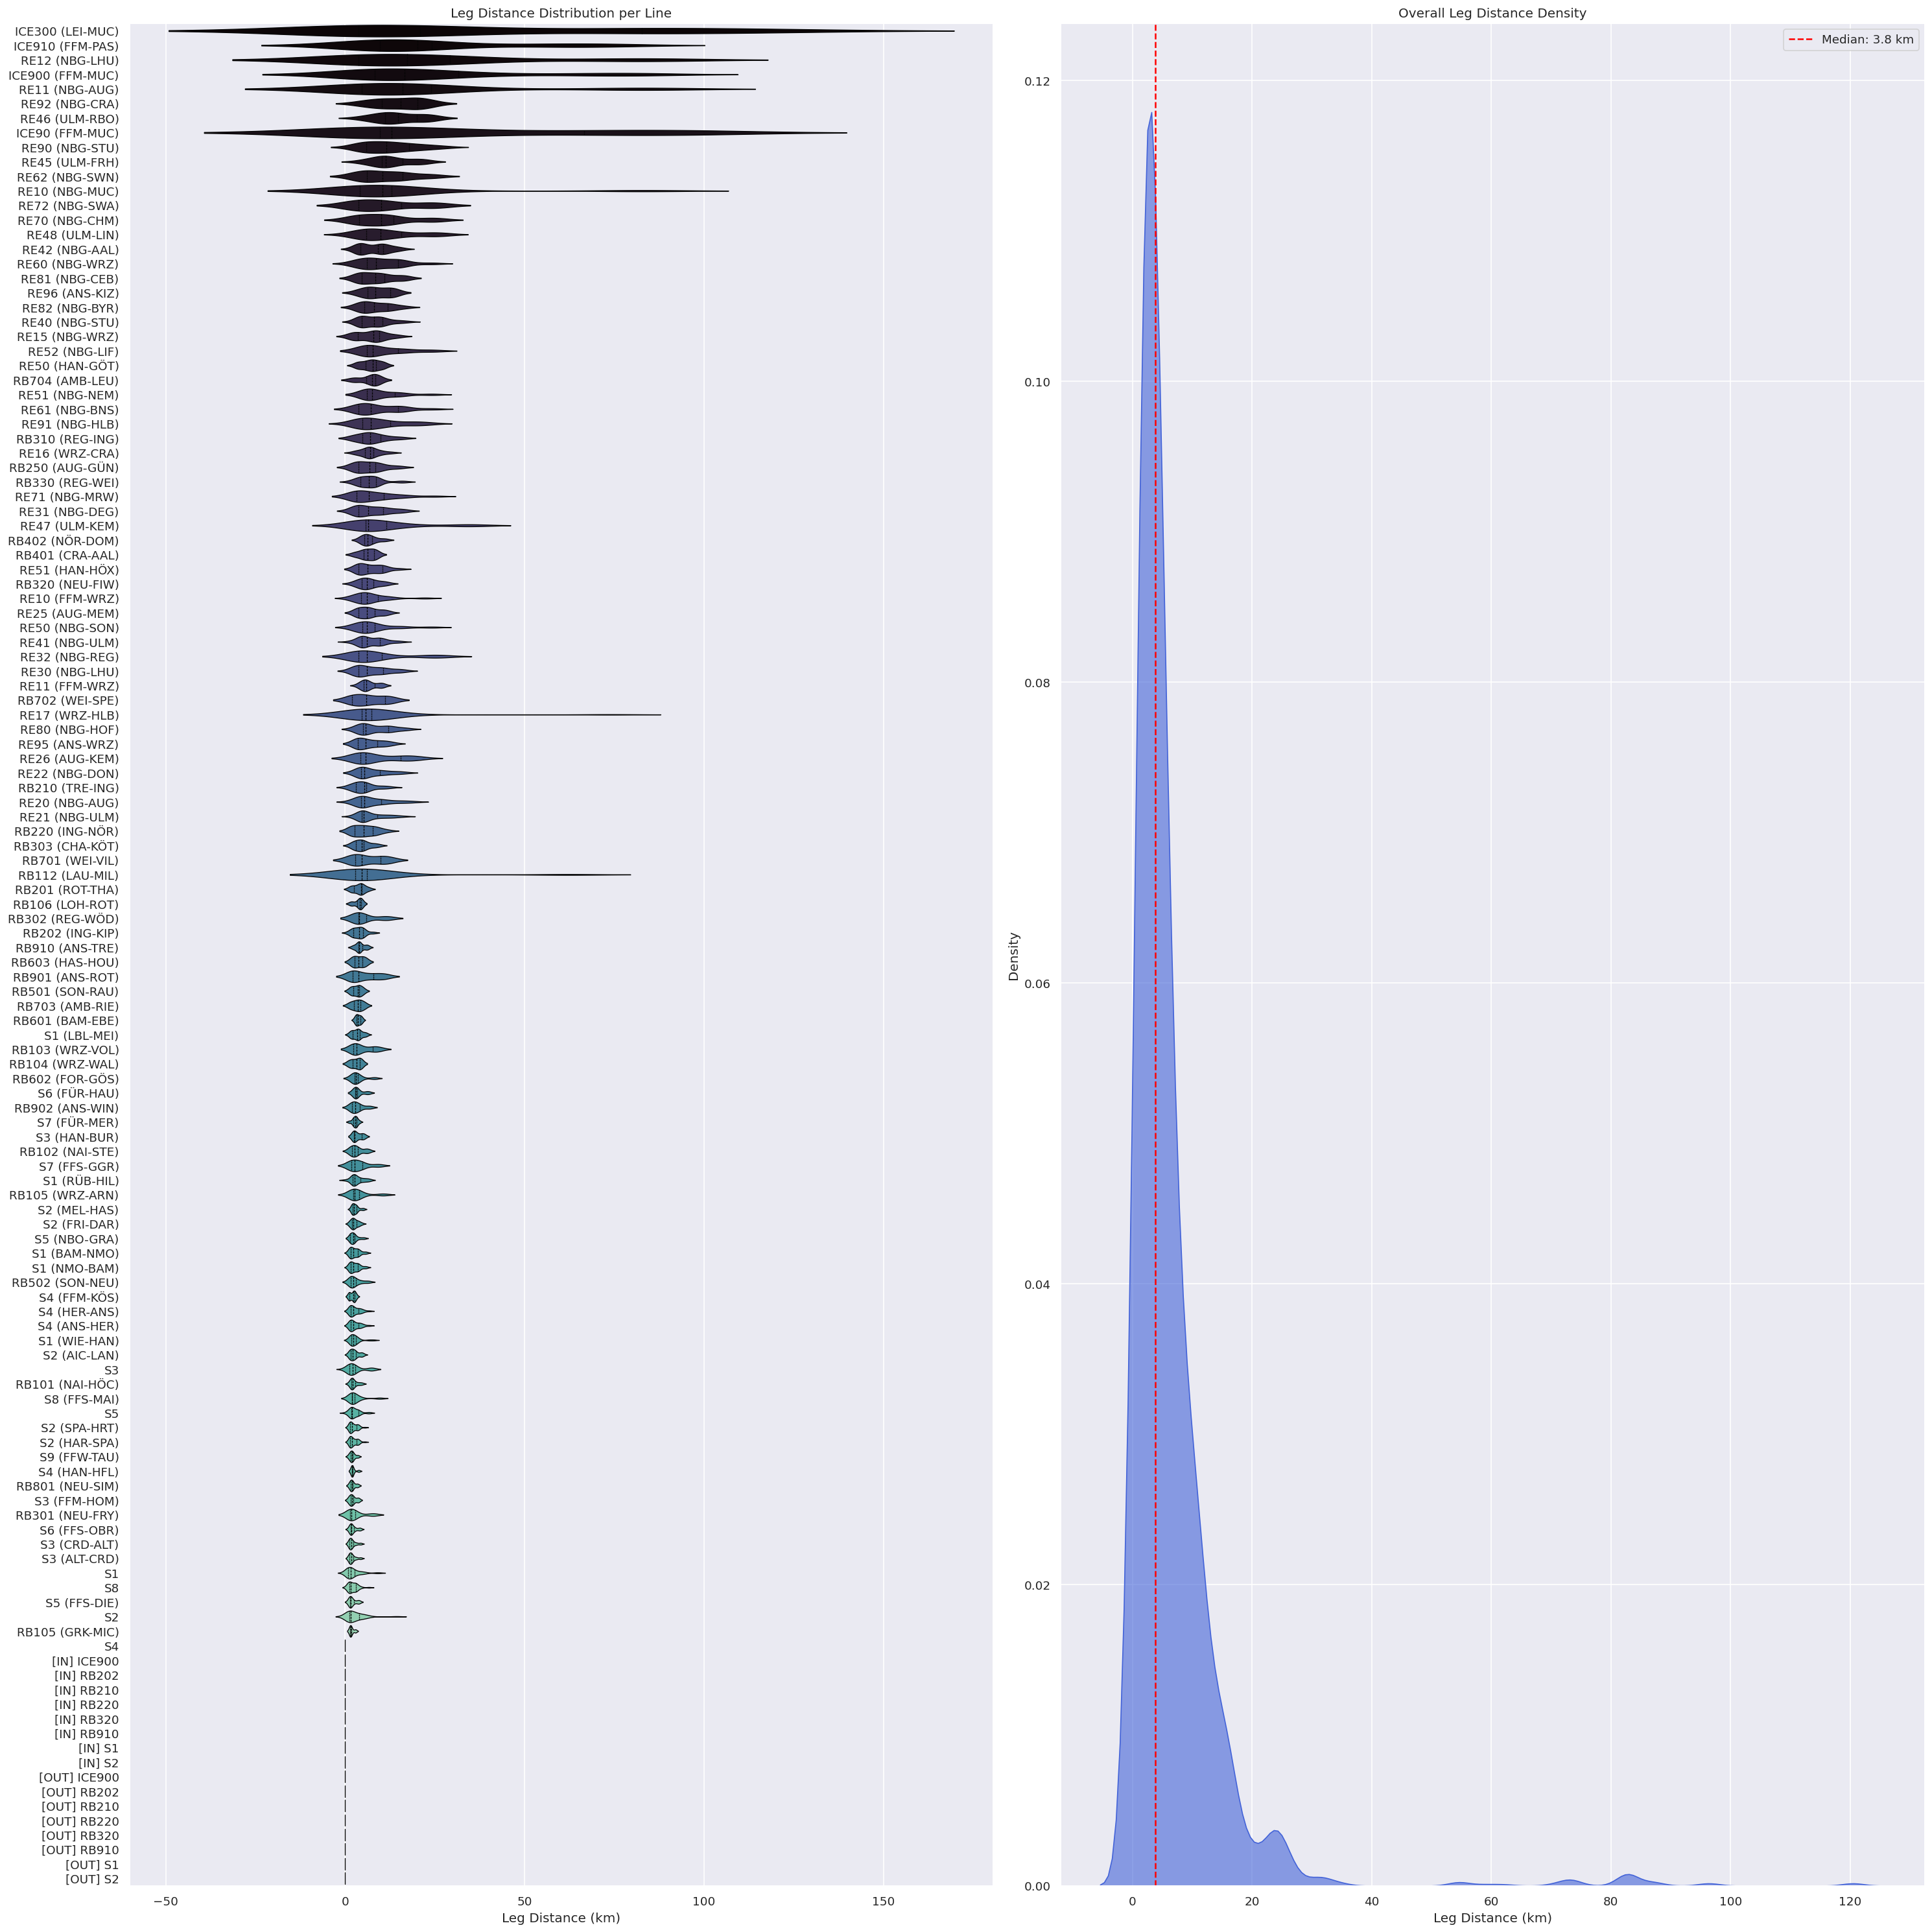

In [5]:
df["leg_km"] = df["leg_distance_m"] / 1000

fig, axes = plt.subplots(1, 2, figsize=(25, 25))

# Violin plot per line
order = df.groupby("line_name")["leg_km"].median().sort_values(ascending=False).index
sns.violinplot(data=df, x="leg_km", y="line_name", order=order,
               ax=axes[0], palette="mako", inner="quart", linewidth=0.8)
axes[0].set_xlabel("Leg Distance (km)")
axes[0].set_ylabel("")
axes[0].set_title("Leg Distance Distribution per Line")

# KDE of all leg distances
sns.kdeplot(df["leg_km"], fill=True, ax=axes[1], color="#4363d8", alpha=0.6)
axes[1].axvline(df["leg_km"].median(), color="red", ls="--",
                label=f"Median: {df['leg_km'].median():.1f} km")
axes[1].set_xlabel("Leg Distance (km)")
axes[1].set_title("Overall Leg Distance Density")
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Implied Speed Between Stops
Estimated average speed between consecutive stops (leg distance / travel time).

In [6]:
# Compute travel time to next stop
speed_df = df.sort_values(["line_id", "stop_index"]).copy()
speed_df["next_arrival"] = speed_df.groupby("line_id")["arrival_s"].shift(-1)
speed_df["travel_s"] = speed_df["next_arrival"] - speed_df["departure_s"]
speed_df["next_leg_m"] = speed_df.groupby("line_id")["leg_distance_m"].shift(-1)
speed_df = speed_df.dropna(subset=["travel_s", "next_leg_m"])
speed_df = speed_df[speed_df["travel_s"] > 0]
speed_df["next_leg_km"] = speed_df["next_leg_m"] / 1000
speed_df["speed_kmh"] = speed_df["next_leg_km"] / (speed_df["travel_s"] / 3600)
speed_df = speed_df[speed_df["speed_kmh"] < 500]

fig = px.scatter(
    speed_df,
    x="next_leg_km",
    y="speed_kmh",
    color="line_name",
    hover_data=["station_name"],
    title="Implied Speed vs Leg Distance",
    labels={
        "next_leg_km": "Leg Distance (km)",
        "speed_kmh": "Speed (km/h)",
        "line_name": "Line"
    },
    opacity=0.7
)

fig.update_layout(height=800)  # höher
fig.show()

## 6. Timetable Timeline (Gantt-style)
Each line shown as a timeline from first departure to last arrival, visualising the span of service.

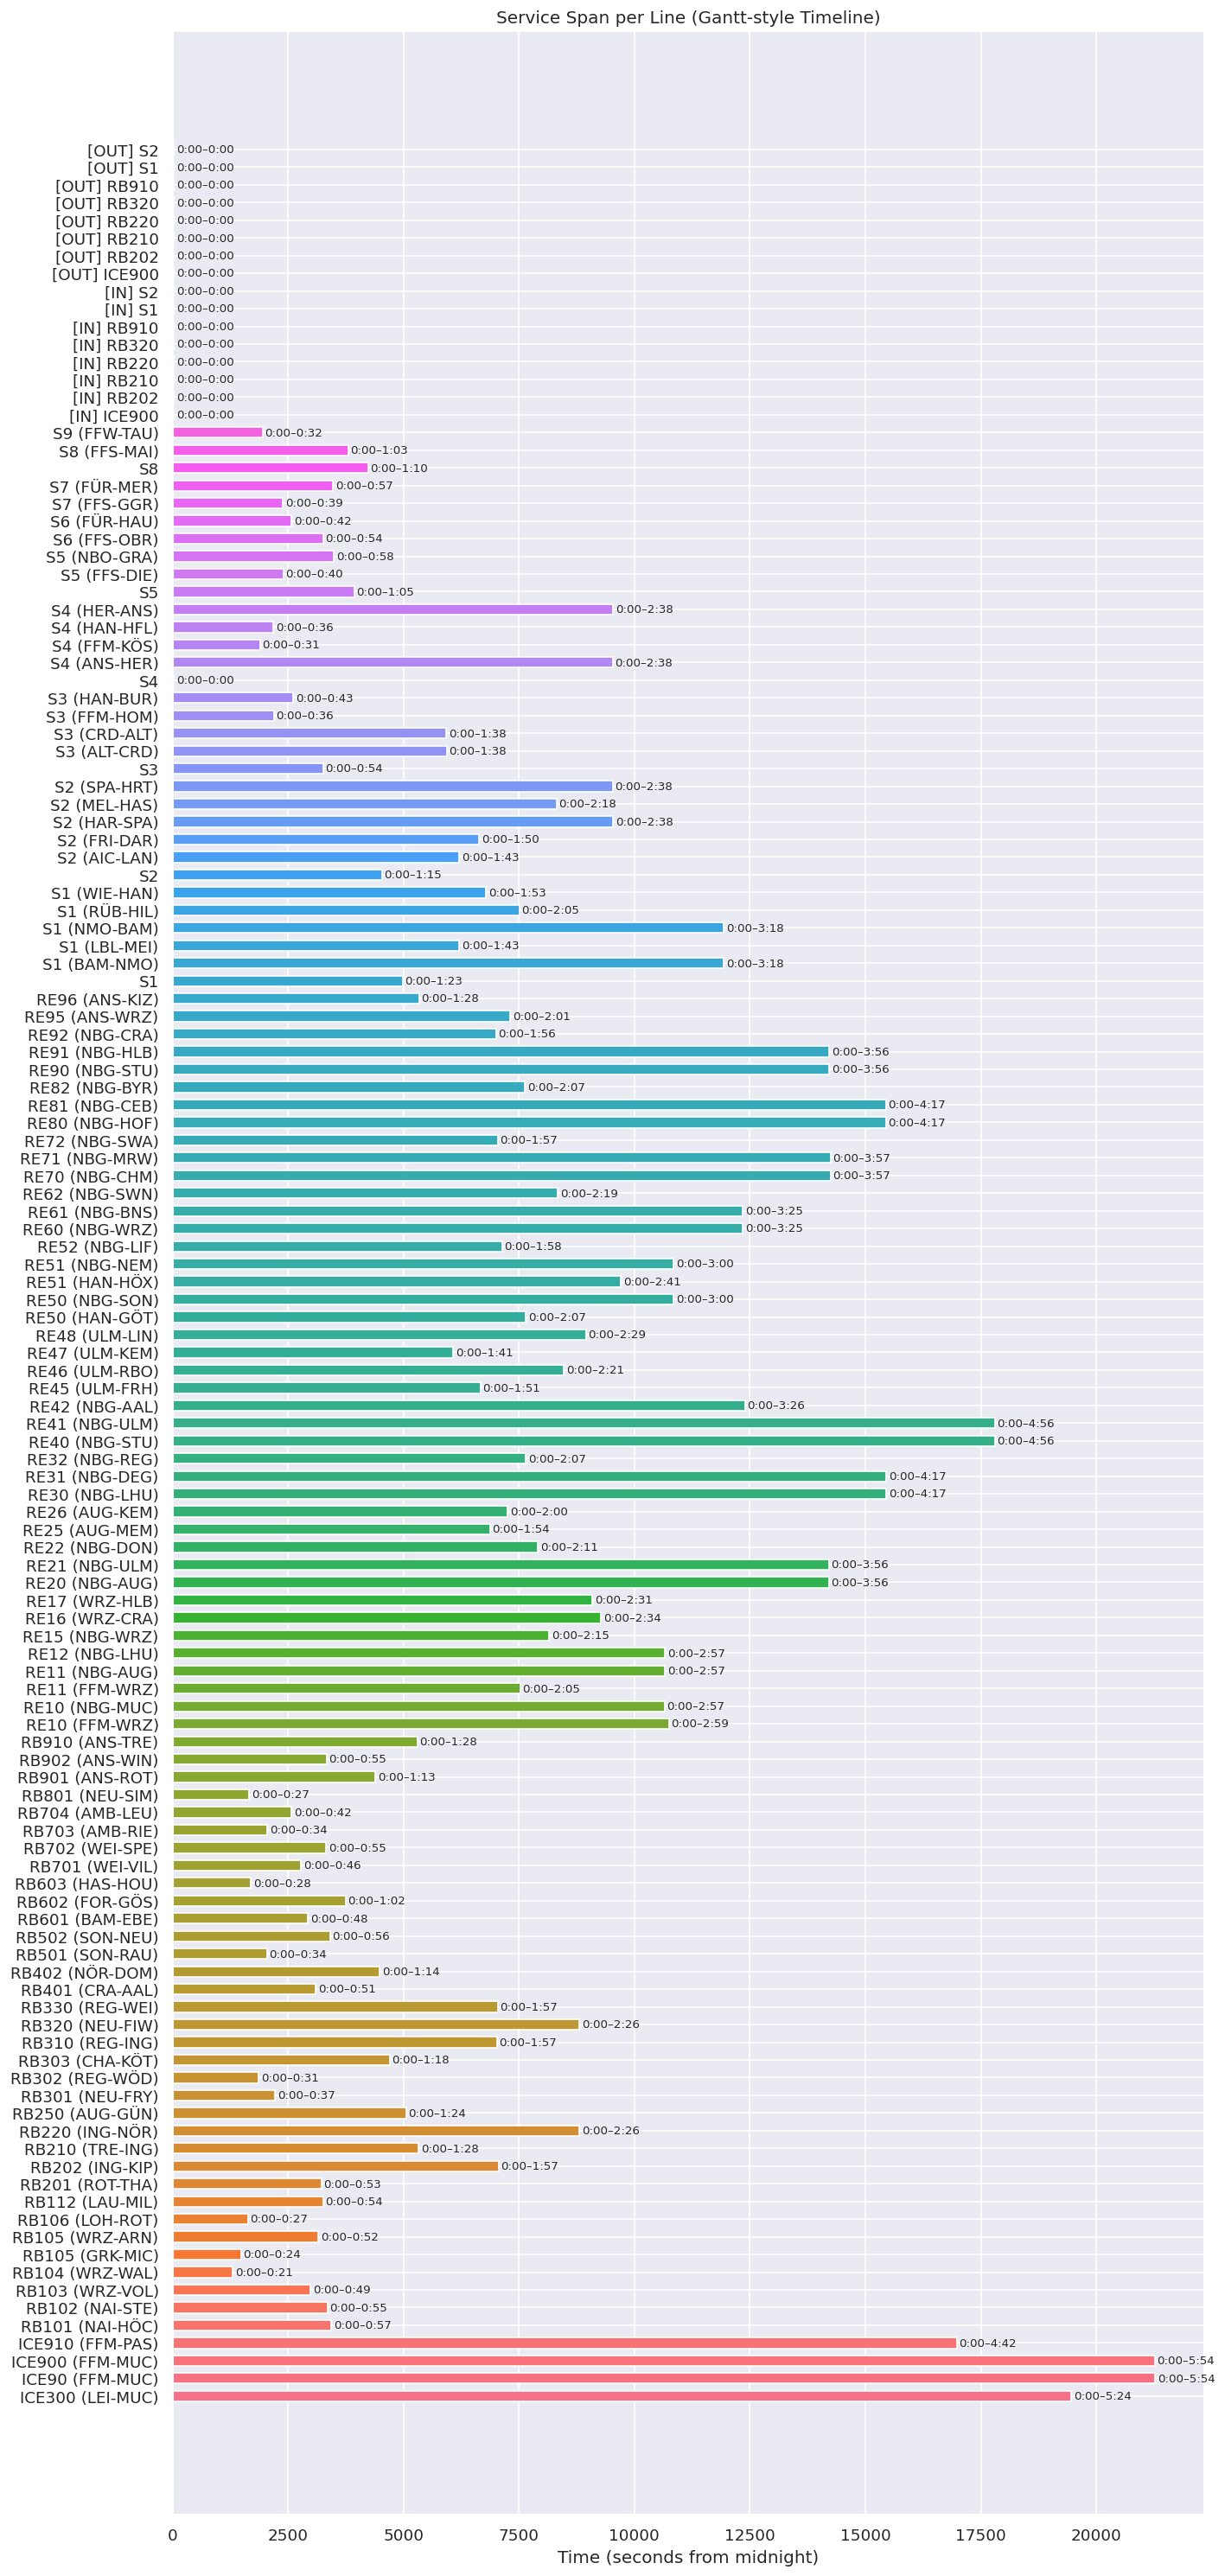

In [8]:
timeline = df.groupby("line_name").agg(
    start=pd.NamedAgg(column="arrival_s", aggfunc="min"),
    end=pd.NamedAgg(column="departure_s", aggfunc="max"),
    n_stops=pd.NamedAgg(column="stop_index", aggfunc="count")
).reset_index().sort_values("start")

# Convert to hours:minutes for display
def s_to_hm(s):
    h, m = divmod(int(s), 3600)
    m = m // 60
    return f"{h}:{m:02d}"

fig, ax = plt.subplots(figsize=(12, 25))
colors = sns.color_palette("husl", len(timeline))
for i, (_, row) in enumerate(timeline.iterrows()):
    ax.barh(row["line_name"], row["end"] - row["start"],
            left=row["start"], color=colors[i], edgecolor="white", height=0.6)
    ax.text(row["end"] + 50, i, f"{s_to_hm(row['start'])}\u2013{s_to_hm(row['end'])}",
            va="center", fontsize=8)

ax.set_xlabel("Time (seconds from midnight)")
ax.set_title("Service Span per Line (Gantt-style Timeline)")
plt.tight_layout()
plt.show()

## Network Summary Statistics

In [14]:
total_km = df["leg_distance_m"].sum() / 1000
avg_stops = df.groupby("line_id")["stop_index"].count().mean()
avg_lines_per_station = station_weight["lines_serving"].mean()
max_hub = station_weight.loc[station_weight["lines_serving"].idxmax()]

summary = pd.DataFrame({
    "Metric": [
        "Total Stations", "Total Lines", "Total Stop Records",
        "Total Network Distance (km)", "Avg Stops per Line",
        "Avg Lines per Station", "Biggest Hub",
        "Mean Dwell Time (s)", "Median Leg Distance (km)"
    ],
    "Value": [
        len(df_stations), len(df_lines), len(df),
        f"{total_km:,.1f}", f"{avg_stops:.1f}",
        f"{avg_lines_per_station:.1f}",
        f"{max_hub['station_name']} ({int(max_hub['lines_serving'])} lines)",
        f"{df['dwell_s'].mean():.0f}",
        f"{df['leg_km'].median():.1f}"
    ]
})
summary.style.hide(axis='index').set_properties(**{'text-align': 'left'})

Metric,Value
Total Stations,1374
Total Lines,140
Total Stop Records,2947
Total Network Distance (km),"18,539.0"
Avg Stops per Line,22.3
Avg Lines per Station,1.7
Biggest Hub,Nürnberg Hauptbahnhof (40 lines)
Mean Dwell Time (s),73
Median Leg Distance (km),3.8
